In [ ]:
 Step 1: Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


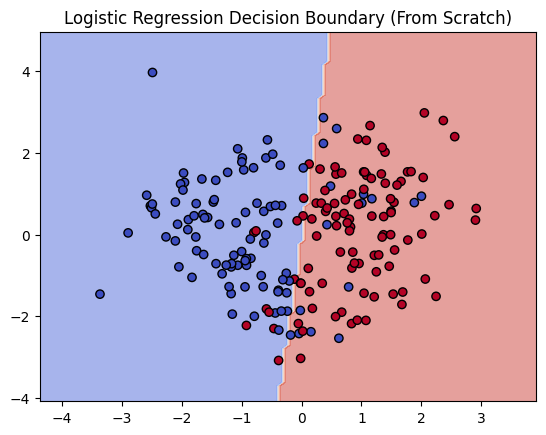

In [ ]:
#   Generate Classification Data
X, y = make_classification(n_samples=200, n_features=2, n_classes=2, n_informative=2, n_redundant=0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#   Implement Logistic Regression
class LogisticRegressionScratch:
    def __init__(self, lr=0.01, epochs=1000):
        self.lr = lr
        self.epochs = epochs

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        self.theta = np.zeros((X.shape[1], 1))
        y = y.reshape(-1, 1)

        for _ in range(self.epochs):
            linear = X.dot(self.theta)
            y_pred = self.sigmoid(linear)
            gradients = X.T.dot(y_pred - y) / X.shape[0]
            self.theta -= self.lr * gradients

    def predict(self, X):
        return (self.sigmoid(X.dot(self.theta)) >= 0.5).astype(int)

# Train model
log_reg = LogisticRegressionScratch(lr=0.1, epochs=2000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

#   Plot Decision Boundary
x1_min, x1_max = X[:, 0].min()-1, X[:, 0].max()+1
x2_min, x2_max = X[:, 1].min()-1, X[:, 1].max()+1
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100),
                       np.linspace(x2_min, x2_max, 100))
Z = log_reg.predict(np.c_[xx1.ravel(), xx2.ravel()])
Z = Z.reshape(xx1.shape)

plt.contourf(xx1, xx2, Z, alpha=0.5, cmap="coolwarm")
plt.scatter(X[:,0], X[:,1], c=y, edgecolors="k", cmap="coolwarm")
plt.title("Logistic Regression Decision Boundary (From Scratch)")
plt.show()


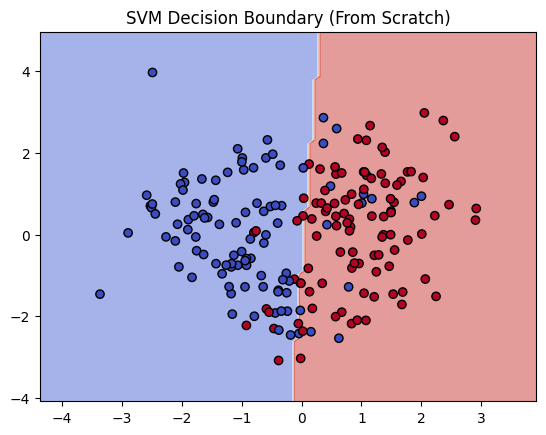

In [ ]:
#   Implement SVM using Gradient Descent (Hinge Loss)
class SVMscratch:
    def __init__(self, lr=0.001, lambda_param=0.01, epochs=1000):
        self.lr = lr
        self.lambda_param = lambda_param
        self.epochs = epochs

    def fit(self, X, y):
        y_ = np.where(y <= 0, -1, 1) # Convert {0,1} to {-1,1}
        self.w = np.zeros(X.shape[1])
        self.b = 0

        for _ in range(self.epochs):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]

    def predict(self, X):
        return np.sign(np.dot(X, self.w) - self.b)

# Train model
svm = SVMscratch(lr=0.001, lambda_param=0.01, epochs=1000)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

#  Plot Decision Boundary
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100),
                       np.linspace(x2_min, x2_max, 100))
Z = svm.predict(np.c_[xx1.ravel(), xx2.ravel()])
Z = Z.reshape(xx1.shape)

plt.contourf(xx1, xx2, Z, alpha=0.5, cmap="coolwarm")
plt.scatter(X[:,0], X[:,1], c=y, edgecolors="k", cmap="coolwarm")
plt.title("SVM Decision Boundary (From Scratch)")
plt.show()


Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.92      0.91        49
           1       0.92      0.90      0.91        51

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100

Confusion Matrix:
 [[45  4]
 [ 5 46]]


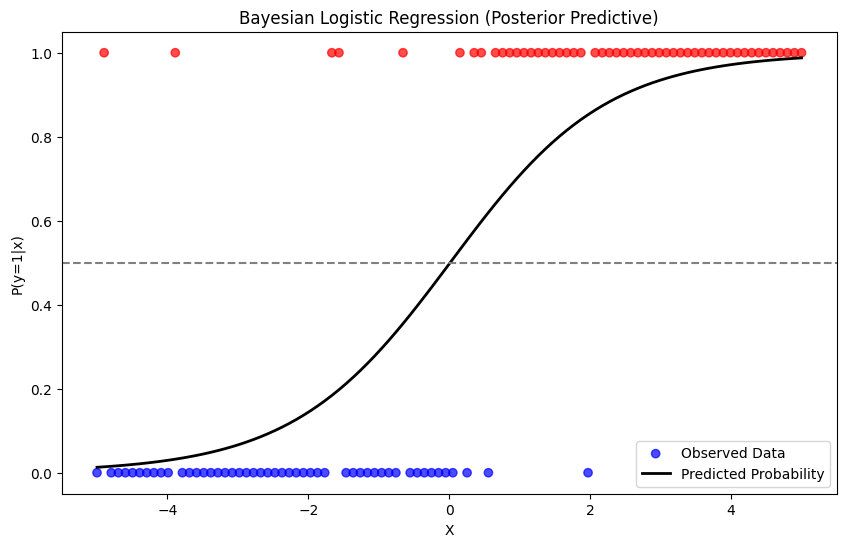

In [ ]:
# Bayesian Logistic Regression from Scratch

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, bernoulli
from sklearn.metrics import confusion_matrix, classification_report

# Generate synthetic dataset
np.random.seed(42)
N = 100
X = np.linspace(-5, 5, N)
y_true = (X > 0).astype(int)   # true boundary at 0
y_obs = bernoulli.rvs(p=y_true*0.9 + (1-y_true)*0.1)  # add some noise

X = X.reshape(-1,1)

# Add bias term
X_design = np.hstack([np.ones((N,1)), X])

# Prior for weights (Gaussian)
def log_prior(w):
    return np.sum(norm.logpdf(w, 0, 1))

# Logistic sigmoid
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Likelihood
def log_likelihood(w, X, y):
    z = X @ w
    return np.sum(y*np.log(sigmoid(z)) + (1-y)*np.log(1 - sigmoid(z)))

# Posterior
def log_posterior(w, X, y):
    return log_prior(w) + log_likelihood(w, X, y)

# Metropolis-Hastings Sampling
def metropolis_hastings(log_posterior, X, y, n_samples=5000, step_size=0.05):
    samples = []
    w = np.zeros(X.shape[1])
    for _ in range(n_samples):
        w_new = w + np.random.normal(0, step_size, size=w.shape)
        log_alpha = log_posterior(w_new, X, y) - log_posterior(w, X, y)
        if np.log(np.random.rand()) < log_alpha:
            w = w_new
        samples.append(w)
    return np.array(samples)

# Run MCMC
samples = metropolis_hastings(log_posterior, X_design, y_obs, n_samples=3000)
burn_in = 1000
posterior_samples = samples[burn_in:]

# Predictive probability
def predict(X, samples):
    X_design = np.hstack([np.ones((X.shape[0],1)), X])
    preds = []
    for w in samples[np.random.choice(len(samples), 500)]:  # subsample
        preds.append(sigmoid(X_design @ w))
    return np.mean(preds, axis=0)

# Evaluate
y_pred_prob = predict(X, posterior_samples)
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Classification Report:\n")
print(classification_report(y_obs, y_pred))

cm = confusion_matrix(y_obs, y_pred)
print("Confusion Matrix:\n", cm)

# Visualization
plt.figure(figsize=(10,6))
plt.scatter(X, y_obs, c=y_obs, cmap="bwr", alpha=0.7, label="Observed Data")
plt.plot(X, y_pred_prob, 'k-', linewidth=2, label="Predicted Probability")
plt.axhline(0.5, ls="--", color="gray")
plt.xlabel("X")
plt.ylabel("P(y=1|x)")
plt.legend()
plt.title("Bayesian Logistic Regression (Posterior Predictive)")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Evaluation metrics
accuracy = accuracy_score(y_obs, y_pred)
precision = precision_score(y_obs, y_pred)
recall = recall_score(y_obs, y_pred)
f1 = f1_score(y_obs, y_pred)
cm = confusion_matrix(y_obs, y_pred)

print("Confusion Matrix:\n", cm)
print(f"\nAccuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")


Confusion Matrix:
 [[45  4]
 [ 5 46]]

Accuracy:  0.9100
Precision: 0.9200
Recall:    0.9020
F1-score:  0.9109
